# Explore the dataset


In this notebook, we will perform an EDA (Exploratory Data Analysis) on the processed Waymo dataset (data in the `processed` folder). In the first part, you will create a function to display 

In [1]:
from utils import get_dataset, get_object_distribution

In [2]:
dataset = get_dataset("/app/data/processed/*.tfrecord")

INFO:tensorflow:Reading unweighted datasets: ['/app/data/processed/*.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['/app/data/processed/*.tfrecord']
INFO:tensorflow:Number of filenames to read: 100
Instructions for updating:
Use `tf.data.Dataset.interleave(map_func, cycle_length, block_length, num_parallel_calls=tf.data.AUTOTUNE)` instead. If sloppy execution is desired, use `tf.data.Options.experimental_deterministic`.
Instructions for updating:
Use `tf.data.Dataset.map()


2022-11-22 21:21:51.185851: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-22 21:21:52.242580: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21525 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090 Ti, pci bus id: 0000:65:00.0, compute capability: 8.6
2022-11-22 21:21:52.243506: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 10414 MB memory:  -> device: 1, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:02:00.0, compute capability: 6.1


## Write a function to display an image and the bounding boxes

Implement the `display_instances` function below. This function takes a batch as an input and display an image with its corresponding bounding boxes. The only requirement is that the classes should be color coded (eg, vehicles in red, pedestrians in blue, cyclist in green).

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from PIL import Image
import tensorflow as tf

colormap = {1: [1, 0, 0], 2: [0, 0, 1], 4: [0, 1, 0]}

def display_instances(batch:tf.data.Dataset):
    """
    This function takes a batch from the dataset and displays the image with 
    the associated bounding boxes.
    """
    for sample in batch:
        _, ax = plt.subplots()
        numpy_image = sample['image'].numpy()
        image = Image.fromarray(numpy_image.astype('uint8'), 'RGB')
        ax.imshow(image)
        for idx in range(len(sample['groundtruth_classes'])):
            ymin = int(sample['groundtruth_boxes'][idx].numpy()[0] * image.height)
            xmin = int(sample['groundtruth_boxes'][idx].numpy()[1] * image.width)
            ymax = int(sample['groundtruth_boxes'][idx].numpy()[2] * image.height)
            xmax = int(sample['groundtruth_boxes'][idx].numpy()[3] * image.width) 
            box = Rectangle(
                (xmin, ymin),
                xmax-xmin,
                ymax-ymin,
                linewidth=1,
                edgecolor=colormap[int(sample['groundtruth_classes'][idx].numpy())],
                facecolor='none',
            )
            ax.add_patch(box)
        plt.tight_layout()
        plt.show()        

## Display 10 images 

Using the dataset created in the second cell and the function you just coded, display 10 random images with the associated bounding boxes. You can use the methods `take` and `shuffle` on the dataset.

2022-11-22 21:21:53.943925: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


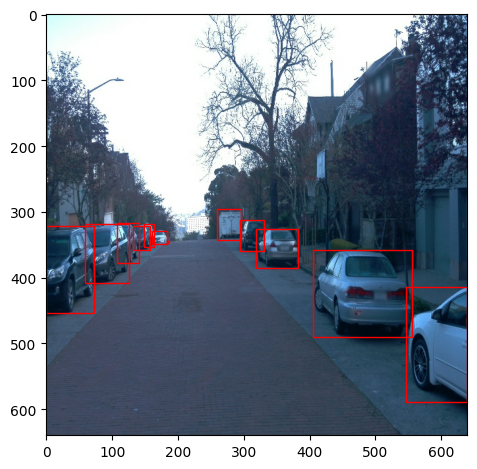

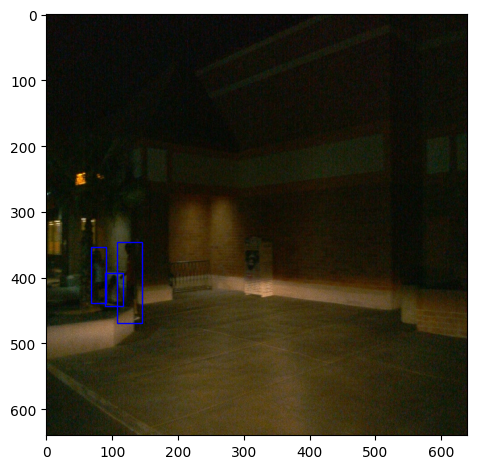

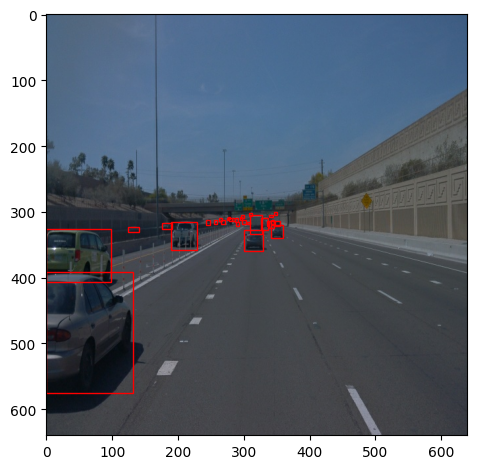

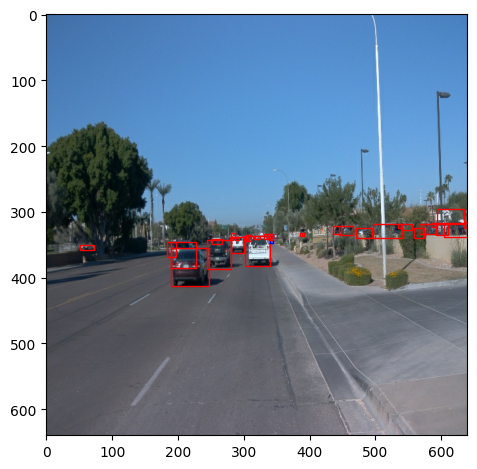

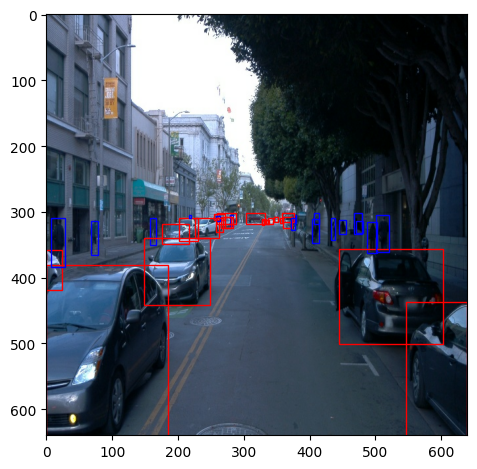

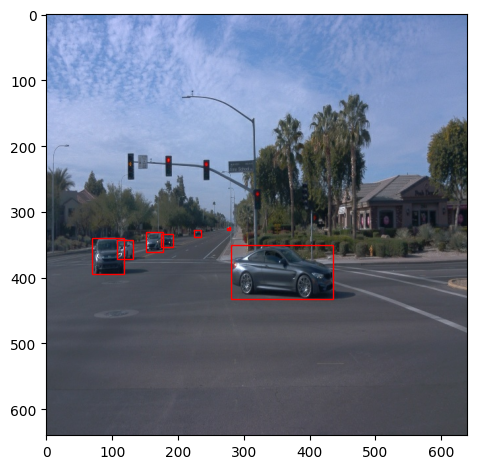

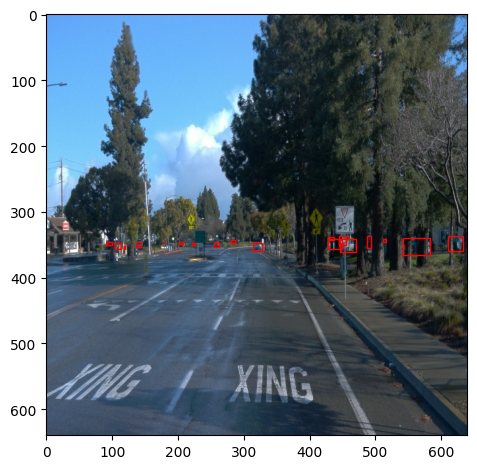

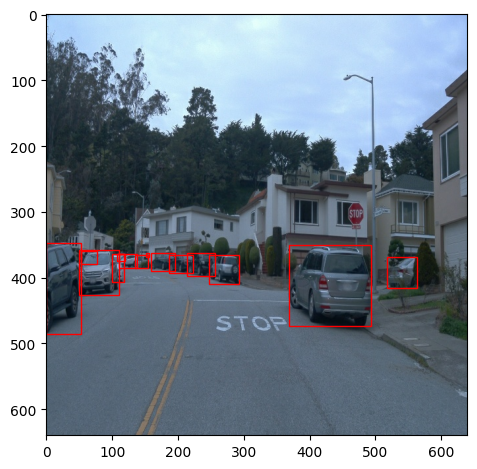

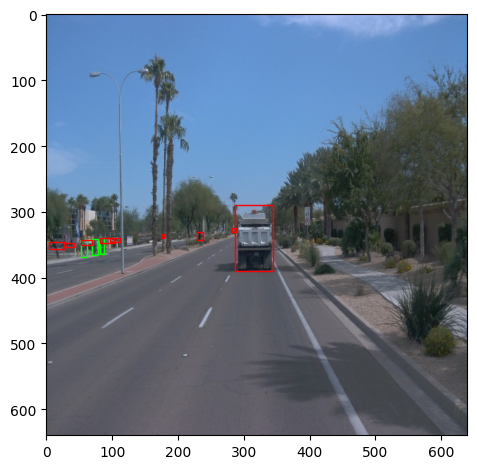

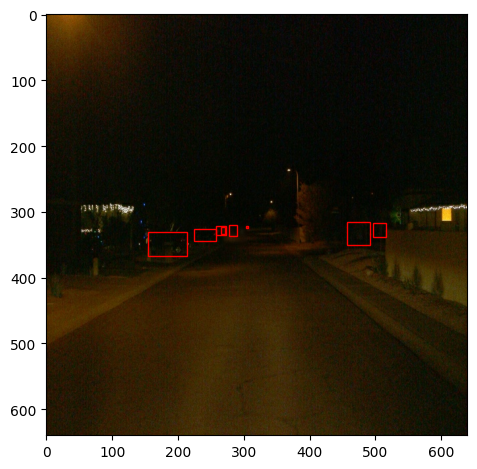

In [4]:
dataset.shuffle(100000)
display_instances(dataset.take(10))

## Additional EDA

In this last part, you are free to perform any additional analysis of the dataset. What else would like to know about the data?
For example, think about data distribution. So far, you have only looked at a single file...

In [5]:
from collections import Counter
import numpy as np

def plot_label_count_bar(labels:Counter):
    """Generate bar plot of all class labels and counts."""
    
    plt.figure()
    categories = list(labels.keys())
    values_np =  np.array(list(labels.values()))
    norm_values_np = values_np / np.sum(list(labels.values()))
    plt.bar(
        categories, 
        norm_values_np,
    )
    for idx, value in enumerate(norm_values_np):
        plt.text(categories[idx], value, str(values_np[idx]))
    plt.ylim(0,1)
    plt.xlabel('Class Id')
    plt.title('Normalized label category counts')
    
def plot_label_density_bar(density:Counter):
    """Generate bar plot of class label instances per frame."""
    
    plt.figure()
    width= 0.8 / len(density.keys())
    for idx, key in enumerate(density.keys()):
        x = np.array(list(density[key].keys()))+(idx*width)
        y = np.array(list(density[key].values()))
        plt.bar(
            x,
            y,
            width=width,
            label=key,
            color=colormap[key]
        )
    plt.title('Object label category density per frame')
    plt.xlabel('Number of objects per frame')
    plt.ylabel('Number of frame occurances')
    plt.legend()
    
def plot_source_file_density_bar(
    source_id_frame_count:Counter(), 
    source_id_obj_count: Counter()
):
    """Generate bar plot of average source file object density."""
    
    plt.figure()
    x = []
    y = []
    for idx, key in enumerate(sorted(source_id_frame_count)):
        x.append(idx)
        y.append(source_id_obj_count[key] / source_id_frame_count[key])
    plt.bar(x,y)
    plt.title('Source file object density')
    plt.xlabel('Source file id')
    plt.ylabel('Average number of objects per frame')

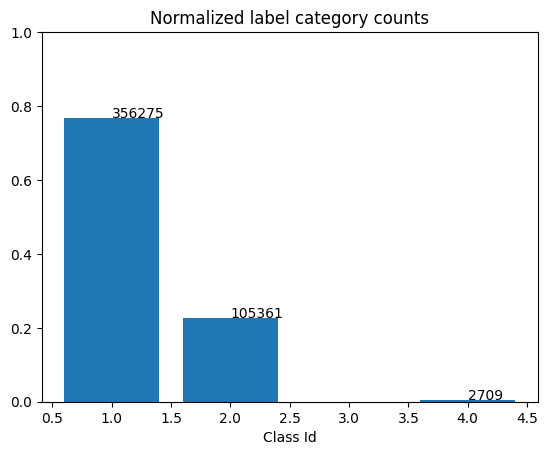

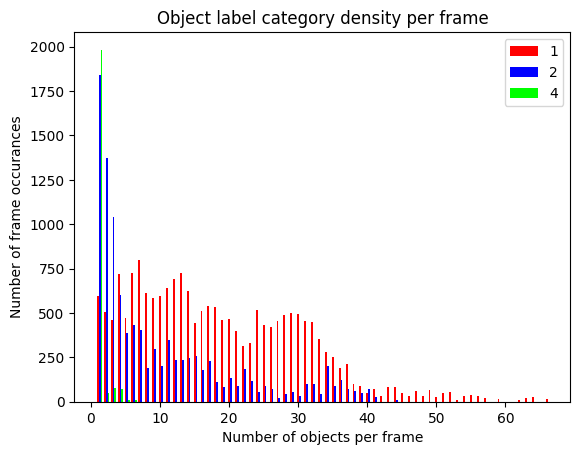

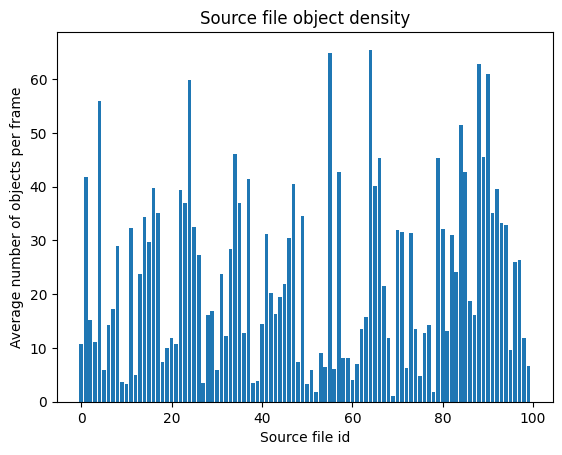

In [6]:
batch_size = 20000
(
    density, 
    labels, 
    source_id_obj_count,
    source_id_frame_count,
) =  get_object_distribution(dataset.take(batch_size))

plot_label_count_bar(labels)
plot_label_density_bar(density)
plot_source_file_density_bar(source_id_frame_count, source_id_obj_count)

## Data splits
Strategy is to maintain object density distrubtion across train,validation, and test splits. The average number of objects present per frame was computed in EDA. To use sklearn **train_test_split** function, we have to formulate a multi-class classification representation. Therefore, each average density will be represented as a one-hot vector of density bins.

In [7]:
from typing import Dict
def __get_average_object_density_from_source_index_array(
    source_idx:np.ndarray, 
    source_id_map:Dict
):
    avg_object_density = np.zeros_like(source_idx)
    for i, idx in enumerate(source_idx):
        source_id = source_id_map[idx]
        avg_object_density[i] = (source_id_obj_count[source_id] / source_id_frame_count[source_id])
    return avg_object_density

In [8]:
from sklearn.model_selection import train_test_split

# Initialize variables
source_idx = np.expand_dims(np.arange(len(source_id_frame_count)), axis=1)
source_ids = {}
max_density_bin = 100
num_bins = 5
density_bins = np.linspace(0,max_density_bin,num_bins+1)
source_avg_object_density_bin = np.zeros([len(source_id_frame_count), num_bins])

# Generate density stratification "labels"
for i, key in enumerate(sorted(source_id_frame_count)):
    source_ids[i] = key
    source_avg_object_density = source_id_obj_count[key] / source_id_frame_count[key]
    # decompose average into one-hot encoding across density bins
    hist, _ = np.histogram(source_avg_object_density, density_bins)
    source_avg_object_density_bin[i][:] = hist

# Generate density stratified train split    
x_train, x_remaining = train_test_split(
    source_idx,
    train_size=0.85, 
    random_state=0, 
    stratify=source_avg_object_density_bin
)


# Generate density stratified validation/test split
x_val, x_test = train_test_split(
    x_remaining,
    train_size=0.60, 
    random_state=0, 
    stratify=source_avg_object_density_bin[np.squeeze(x_remaining)]
)

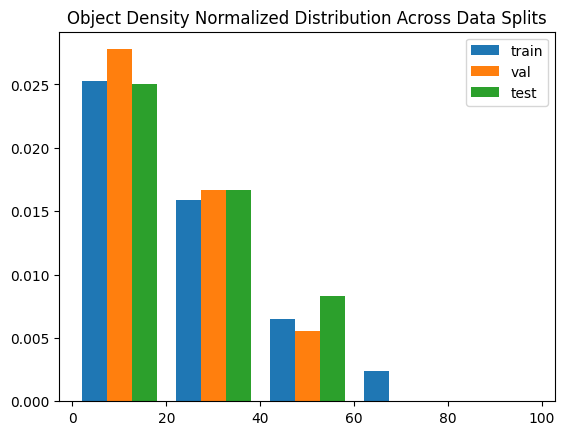

In [9]:
# Verify proportional density distribution across train, validation, test splits. 
train_avg_density = __get_average_object_density_from_source_index_array(
    np.squeeze(x_train),
    source_ids
)
val_avg_density = __get_average_object_density_from_source_index_array(
    np.squeeze(x_val),
    source_ids
)
test_avg_density = __get_average_object_density_from_source_index_array(
    np.squeeze(x_test),
    source_ids
)

# Visualize object density distrubutions across train, validation, test splits
plt.hist(
    [
        train_avg_density,
        val_avg_density,
        test_avg_density,
    ],
    density_bins, 
    density=True,
    label=['train',
           'val',
           'test'
    ]
)
plt.title("Object Density Normalized Distribution Across Data Splits")
plt.legend(loc='upper right')
plt.show()